In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CelebADataset(Dataset):
    def __init__(self, folder_path, image_size=128, transform=None):
        self.folder_path = folder_path
        self.image_size = image_size
        self.transform = transform
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

folder_path = "celebA_class_dataset/Smiling_Male_Young"
#folder_path = "celebA_class_dataset/Smiling_Young_Not_Male"

batch_size=256
dataset = CelebADataset(folder_path=folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)

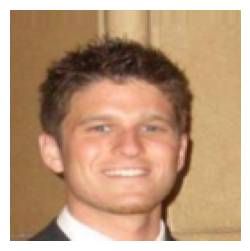

In [2]:
image_tensor = (dataset[6]+1)/2

# Convert tensor to numpy and rearrange dimensions to (height, width, channels)
image = image_tensor.permute(1, 2, 0).numpy()
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space (mean and variance for reparameterization)
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)  # Flatten the features to latent dimension
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),  # Reshape the input to 256x8x8 for the decoder
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 64x64 -> 128x128
            nn.Tanh()  # To map the output to [-1, 1]
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        z = self.decoder_fc(z)
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

latent_dim = 1024
model = VAE(latent_dim=latent_dim).to(device)

In [4]:
def loss_function(reconstructed_x, x, mu, logvar, lambda_kl=1.0):
    BCE = nn.functional.mse_loss(reconstructed_x, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + lambda_kl * KL_divergence

learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, optimizer, epochs=10, lambda_kl=1.0):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        with tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for batch_idx, data in enumerate(pbar):
                data = data.to(device)
                optimizer.zero_grad()
                reconstructed_x, mu, logvar = model(data)
                loss = loss_function(reconstructed_x, data, mu, logvar, lambda_kl)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (batch_idx + 1))

        avg_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

In [5]:
### Train Model
lambda_kl = 1
epochs = 150
train(dataloader, model, optimizer, epochs=epochs, lambda_kl=lambda_kl)

Epoch 1/150: 100%|██████████| 80/80 [00:04<00:00, 16.86batch/s, loss=3.58e+6]


Epoch [1/150], Average Loss: 13981.9812


Epoch 2/150: 100%|██████████| 80/80 [00:04<00:00, 18.51batch/s, loss=2.05e+6]


Epoch [2/150], Average Loss: 8000.8366


Epoch 3/150: 100%|██████████| 80/80 [00:04<00:00, 19.45batch/s, loss=1.26e+6]


Epoch [3/150], Average Loss: 4919.4300


Epoch 4/150: 100%|██████████| 80/80 [00:04<00:00, 19.10batch/s, loss=1.1e+6] 


Epoch [4/150], Average Loss: 4299.6323


Epoch 5/150: 100%|██████████| 80/80 [00:04<00:00, 19.65batch/s, loss=1.01e+6]


Epoch [5/150], Average Loss: 3963.4564


Epoch 6/150: 100%|██████████| 80/80 [00:04<00:00, 19.31batch/s, loss=9.47e+5]


Epoch [6/150], Average Loss: 3702.4991


Epoch 7/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=8.59e+5]


Epoch [7/150], Average Loss: 3355.2171


Epoch 8/150: 100%|██████████| 80/80 [00:04<00:00, 19.39batch/s, loss=8.03e+5]


Epoch [8/150], Average Loss: 3138.1280


Epoch 9/150: 100%|██████████| 80/80 [00:04<00:00, 18.96batch/s, loss=7.64e+5]


Epoch [9/150], Average Loss: 2985.5128


Epoch 10/150: 100%|██████████| 80/80 [00:04<00:00, 19.24batch/s, loss=7.37e+5]


Epoch [10/150], Average Loss: 2879.9804


Epoch 11/150: 100%|██████████| 80/80 [00:04<00:00, 19.17batch/s, loss=7.08e+5]


Epoch [11/150], Average Loss: 2768.1101


Epoch 12/150: 100%|██████████| 80/80 [00:04<00:00, 18.99batch/s, loss=6.87e+5]


Epoch [12/150], Average Loss: 2684.0673


Epoch 13/150: 100%|██████████| 80/80 [00:04<00:00, 19.08batch/s, loss=6.63e+5]


Epoch [13/150], Average Loss: 2592.7809


Epoch 14/150: 100%|██████████| 80/80 [00:04<00:00, 19.09batch/s, loss=6.43e+5]


Epoch [14/150], Average Loss: 2512.6114


Epoch 15/150: 100%|██████████| 80/80 [00:04<00:00, 19.18batch/s, loss=6.26e+5]


Epoch [15/150], Average Loss: 2447.8776


Epoch 16/150: 100%|██████████| 80/80 [00:04<00:00, 18.99batch/s, loss=6.1e+5] 


Epoch [16/150], Average Loss: 2384.6560


Epoch 17/150: 100%|██████████| 80/80 [00:04<00:00, 19.68batch/s, loss=5.95e+5]


Epoch [17/150], Average Loss: 2326.2547


Epoch 18/150: 100%|██████████| 80/80 [00:04<00:00, 19.14batch/s, loss=5.8e+5] 


Epoch [18/150], Average Loss: 2267.4046


Epoch 19/150: 100%|██████████| 80/80 [00:04<00:00, 19.10batch/s, loss=5.68e+5]


Epoch [19/150], Average Loss: 2220.0086


Epoch 20/150: 100%|██████████| 80/80 [00:04<00:00, 19.17batch/s, loss=5.58e+5]


Epoch [20/150], Average Loss: 2179.0828


Epoch 21/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=5.46e+5]


Epoch [21/150], Average Loss: 2131.9713


Epoch 22/150: 100%|██████████| 80/80 [00:04<00:00, 19.52batch/s, loss=5.36e+5]


Epoch [22/150], Average Loss: 2096.4934


Epoch 23/150: 100%|██████████| 80/80 [00:04<00:00, 19.38batch/s, loss=5.27e+5]


Epoch [23/150], Average Loss: 2060.1660


Epoch 24/150: 100%|██████████| 80/80 [00:04<00:00, 19.41batch/s, loss=5.18e+5]


Epoch [24/150], Average Loss: 2023.9672


Epoch 25/150: 100%|██████████| 80/80 [00:04<00:00, 18.93batch/s, loss=5.1e+5] 


Epoch [25/150], Average Loss: 1992.4459


Epoch 26/150: 100%|██████████| 80/80 [00:04<00:00, 19.16batch/s, loss=5.04e+5]


Epoch [26/150], Average Loss: 1970.5813


Epoch 27/150: 100%|██████████| 80/80 [00:04<00:00, 19.62batch/s, loss=4.96e+5]


Epoch [27/150], Average Loss: 1939.6706


Epoch 28/150: 100%|██████████| 80/80 [00:04<00:00, 19.50batch/s, loss=4.9e+5] 


Epoch [28/150], Average Loss: 1913.4312


Epoch 29/150: 100%|██████████| 80/80 [00:04<00:00, 19.31batch/s, loss=4.85e+5]


Epoch [29/150], Average Loss: 1893.8135


Epoch 30/150: 100%|██████████| 80/80 [00:04<00:00, 19.51batch/s, loss=4.78e+5]


Epoch [30/150], Average Loss: 1868.3047


Epoch 31/150: 100%|██████████| 80/80 [00:04<00:00, 19.79batch/s, loss=4.74e+5]


Epoch [31/150], Average Loss: 1852.3404


Epoch 32/150: 100%|██████████| 80/80 [00:04<00:00, 19.29batch/s, loss=4.68e+5]


Epoch [32/150], Average Loss: 1828.8737


Epoch 33/150: 100%|██████████| 80/80 [00:04<00:00, 19.38batch/s, loss=4.63e+5]


Epoch [33/150], Average Loss: 1810.6690


Epoch 34/150: 100%|██████████| 80/80 [00:04<00:00, 19.15batch/s, loss=4.57e+5]


Epoch [34/150], Average Loss: 1785.5918


Epoch 35/150: 100%|██████████| 80/80 [00:04<00:00, 18.78batch/s, loss=4.53e+5]


Epoch [35/150], Average Loss: 1770.5597


Epoch 36/150: 100%|██████████| 80/80 [00:04<00:00, 19.06batch/s, loss=4.47e+5]


Epoch [36/150], Average Loss: 1747.2811


Epoch 37/150: 100%|██████████| 80/80 [00:04<00:00, 19.19batch/s, loss=4.43e+5]


Epoch [37/150], Average Loss: 1731.0775


Epoch 38/150: 100%|██████████| 80/80 [00:04<00:00, 18.97batch/s, loss=4.39e+5]


Epoch [38/150], Average Loss: 1714.9586


Epoch 39/150: 100%|██████████| 80/80 [00:04<00:00, 19.42batch/s, loss=4.35e+5]


Epoch [39/150], Average Loss: 1699.2182


Epoch 40/150: 100%|██████████| 80/80 [00:04<00:00, 19.14batch/s, loss=4.3e+5] 


Epoch [40/150], Average Loss: 1680.9062


Epoch 41/150: 100%|██████████| 80/80 [00:04<00:00, 19.39batch/s, loss=4.28e+5]


Epoch [41/150], Average Loss: 1672.2648


Epoch 42/150: 100%|██████████| 80/80 [00:04<00:00, 19.25batch/s, loss=4.23e+5]


Epoch [42/150], Average Loss: 1654.2786


Epoch 43/150: 100%|██████████| 80/80 [00:04<00:00, 18.72batch/s, loss=4.2e+5] 


Epoch [43/150], Average Loss: 1642.7407


Epoch 44/150: 100%|██████████| 80/80 [00:04<00:00, 18.76batch/s, loss=4.18e+5]


Epoch [44/150], Average Loss: 1631.7059


Epoch 45/150: 100%|██████████| 80/80 [00:04<00:00, 19.41batch/s, loss=4.14e+5]


Epoch [45/150], Average Loss: 1617.5436


Epoch 46/150: 100%|██████████| 80/80 [00:04<00:00, 19.25batch/s, loss=4.11e+5]


Epoch [46/150], Average Loss: 1607.0145


Epoch 47/150: 100%|██████████| 80/80 [00:04<00:00, 19.03batch/s, loss=4.09e+5]


Epoch [47/150], Average Loss: 1599.0825


Epoch 48/150: 100%|██████████| 80/80 [00:04<00:00, 19.22batch/s, loss=4.06e+5]


Epoch [48/150], Average Loss: 1587.6754


Epoch 49/150: 100%|██████████| 80/80 [00:04<00:00, 18.72batch/s, loss=4.04e+5]


Epoch [49/150], Average Loss: 1577.9656


Epoch 50/150: 100%|██████████| 80/80 [00:04<00:00, 18.92batch/s, loss=4.02e+5]


Epoch [50/150], Average Loss: 1570.9769


Epoch 51/150: 100%|██████████| 80/80 [00:04<00:00, 19.39batch/s, loss=3.99e+5]


Epoch [51/150], Average Loss: 1559.4516


Epoch 52/150: 100%|██████████| 80/80 [00:04<00:00, 18.90batch/s, loss=3.97e+5]


Epoch [52/150], Average Loss: 1549.9626


Epoch 53/150: 100%|██████████| 80/80 [00:04<00:00, 19.38batch/s, loss=3.95e+5]


Epoch [53/150], Average Loss: 1543.2094


Epoch 54/150: 100%|██████████| 80/80 [00:04<00:00, 19.42batch/s, loss=3.92e+5]


Epoch [54/150], Average Loss: 1532.8691


Epoch 55/150: 100%|██████████| 80/80 [00:04<00:00, 19.13batch/s, loss=3.91e+5]


Epoch [55/150], Average Loss: 1527.0369


Epoch 56/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=3.9e+5] 


Epoch [56/150], Average Loss: 1524.6692


Epoch 57/150: 100%|██████████| 80/80 [00:04<00:00, 19.54batch/s, loss=3.87e+5]


Epoch [57/150], Average Loss: 1513.1345


Epoch 58/150: 100%|██████████| 80/80 [00:04<00:00, 19.57batch/s, loss=3.85e+5]


Epoch [58/150], Average Loss: 1505.6148


Epoch 59/150: 100%|██████████| 80/80 [00:04<00:00, 19.31batch/s, loss=3.84e+5]


Epoch [59/150], Average Loss: 1498.8740


Epoch 60/150: 100%|██████████| 80/80 [00:04<00:00, 19.02batch/s, loss=3.82e+5]


Epoch [60/150], Average Loss: 1492.7986


Epoch 61/150: 100%|██████████| 80/80 [00:04<00:00, 19.09batch/s, loss=3.81e+5]


Epoch [61/150], Average Loss: 1487.5412


Epoch 62/150: 100%|██████████| 80/80 [00:04<00:00, 19.12batch/s, loss=3.79e+5]


Epoch [62/150], Average Loss: 1480.2933


Epoch 63/150: 100%|██████████| 80/80 [00:04<00:00, 19.32batch/s, loss=3.77e+5]


Epoch [63/150], Average Loss: 1471.9079


Epoch 64/150: 100%|██████████| 80/80 [00:04<00:00, 19.31batch/s, loss=3.75e+5]


Epoch [64/150], Average Loss: 1465.8461


Epoch 65/150: 100%|██████████| 80/80 [00:04<00:00, 19.10batch/s, loss=3.75e+5]


Epoch [65/150], Average Loss: 1464.4067


Epoch 66/150: 100%|██████████| 80/80 [00:04<00:00, 18.95batch/s, loss=3.73e+5]


Epoch [66/150], Average Loss: 1457.1231


Epoch 67/150: 100%|██████████| 80/80 [00:04<00:00, 19.17batch/s, loss=3.71e+5]


Epoch [67/150], Average Loss: 1450.2283


Epoch 68/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=3.7e+5] 


Epoch [68/150], Average Loss: 1446.3806


Epoch 69/150: 100%|██████████| 80/80 [00:04<00:00, 19.56batch/s, loss=3.69e+5]


Epoch [69/150], Average Loss: 1442.3650


Epoch 70/150: 100%|██████████| 80/80 [00:04<00:00, 19.41batch/s, loss=3.67e+5]


Epoch [70/150], Average Loss: 1435.2359


Epoch 71/150: 100%|██████████| 80/80 [00:04<00:00, 19.46batch/s, loss=3.66e+5]


Epoch [71/150], Average Loss: 1429.2797


Epoch 72/150: 100%|██████████| 80/80 [00:04<00:00, 19.17batch/s, loss=3.65e+5]


Epoch [72/150], Average Loss: 1426.4240


Epoch 73/150: 100%|██████████| 80/80 [00:04<00:00, 18.89batch/s, loss=3.65e+5]


Epoch [73/150], Average Loss: 1424.6101


Epoch 74/150: 100%|██████████| 80/80 [00:04<00:00, 19.48batch/s, loss=3.62e+5]


Epoch [74/150], Average Loss: 1415.6097


Epoch 75/150: 100%|██████████| 80/80 [00:04<00:00, 19.09batch/s, loss=3.62e+5]


Epoch [75/150], Average Loss: 1413.0823


Epoch 76/150: 100%|██████████| 80/80 [00:04<00:00, 19.38batch/s, loss=3.61e+5]


Epoch [76/150], Average Loss: 1409.7723


Epoch 77/150: 100%|██████████| 80/80 [00:04<00:00, 19.07batch/s, loss=3.6e+5] 


Epoch [77/150], Average Loss: 1406.3439


Epoch 78/150: 100%|██████████| 80/80 [00:04<00:00, 18.60batch/s, loss=3.58e+5]


Epoch [78/150], Average Loss: 1397.7879


Epoch 79/150: 100%|██████████| 80/80 [00:06<00:00, 13.06batch/s, loss=3.57e+5]


Epoch [79/150], Average Loss: 1394.9871


Epoch 80/150: 100%|██████████| 80/80 [00:04<00:00, 19.46batch/s, loss=3.56e+5]


Epoch [80/150], Average Loss: 1391.0462


Epoch 81/150: 100%|██████████| 80/80 [00:04<00:00, 19.50batch/s, loss=3.55e+5]


Epoch [81/150], Average Loss: 1388.9278


Epoch 82/150: 100%|██████████| 80/80 [00:04<00:00, 19.18batch/s, loss=3.54e+5]


Epoch [82/150], Average Loss: 1382.2737


Epoch 83/150: 100%|██████████| 80/80 [00:04<00:00, 19.15batch/s, loss=3.53e+5]


Epoch [83/150], Average Loss: 1380.2327


Epoch 84/150: 100%|██████████| 80/80 [00:04<00:00, 19.24batch/s, loss=3.52e+5]


Epoch [84/150], Average Loss: 1376.6942


Epoch 85/150: 100%|██████████| 80/80 [00:04<00:00, 19.40batch/s, loss=3.51e+5]


Epoch [85/150], Average Loss: 1371.6496


Epoch 86/150: 100%|██████████| 80/80 [00:04<00:00, 19.71batch/s, loss=3.5e+5] 


Epoch [86/150], Average Loss: 1368.3735


Epoch 87/150: 100%|██████████| 80/80 [00:04<00:00, 19.14batch/s, loss=3.5e+5] 


Epoch [87/150], Average Loss: 1367.6872


Epoch 88/150: 100%|██████████| 80/80 [00:04<00:00, 18.98batch/s, loss=3.49e+5]


Epoch [88/150], Average Loss: 1363.1155


Epoch 89/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=3.47e+5]


Epoch [89/150], Average Loss: 1357.2724


Epoch 90/150: 100%|██████████| 80/80 [00:04<00:00, 19.42batch/s, loss=3.47e+5]


Epoch [90/150], Average Loss: 1357.1925


Epoch 91/150: 100%|██████████| 80/80 [00:04<00:00, 19.99batch/s, loss=3.46e+5]


Epoch [91/150], Average Loss: 1351.6055


Epoch 92/150: 100%|██████████| 80/80 [00:04<00:00, 19.42batch/s, loss=3.45e+5]


Epoch [92/150], Average Loss: 1346.7568


Epoch 93/150: 100%|██████████| 80/80 [00:04<00:00, 19.31batch/s, loss=3.45e+5]


Epoch [93/150], Average Loss: 1346.3737


Epoch 94/150: 100%|██████████| 80/80 [00:04<00:00, 19.44batch/s, loss=3.44e+5]


Epoch [94/150], Average Loss: 1343.9492


Epoch 95/150: 100%|██████████| 80/80 [00:04<00:00, 18.89batch/s, loss=3.43e+5]


Epoch [95/150], Average Loss: 1339.4888


Epoch 96/150: 100%|██████████| 80/80 [00:04<00:00, 19.14batch/s, loss=3.42e+5]


Epoch [96/150], Average Loss: 1337.4298


Epoch 97/150: 100%|██████████| 80/80 [00:04<00:00, 19.28batch/s, loss=3.41e+5]


Epoch [97/150], Average Loss: 1334.3927


Epoch 98/150: 100%|██████████| 80/80 [00:04<00:00, 19.27batch/s, loss=3.42e+5]


Epoch [98/150], Average Loss: 1334.6647


Epoch 99/150: 100%|██████████| 80/80 [00:04<00:00, 19.19batch/s, loss=3.4e+5] 


Epoch [99/150], Average Loss: 1327.1434


Epoch 100/150: 100%|██████████| 80/80 [00:04<00:00, 19.00batch/s, loss=3.39e+5]


Epoch [100/150], Average Loss: 1323.7922


Epoch 101/150: 100%|██████████| 80/80 [00:04<00:00, 19.67batch/s, loss=3.38e+5]


Epoch [101/150], Average Loss: 1321.6441


Epoch 102/150: 100%|██████████| 80/80 [00:04<00:00, 19.26batch/s, loss=3.38e+5]


Epoch [102/150], Average Loss: 1320.8408


Epoch 103/150: 100%|██████████| 80/80 [00:04<00:00, 19.83batch/s, loss=3.37e+5]


Epoch [103/150], Average Loss: 1317.5720


Epoch 104/150: 100%|██████████| 80/80 [00:04<00:00, 19.56batch/s, loss=3.37e+5]


Epoch [104/150], Average Loss: 1315.0850


Epoch 105/150: 100%|██████████| 80/80 [00:04<00:00, 18.99batch/s, loss=3.36e+5]


Epoch [105/150], Average Loss: 1314.0590


Epoch 106/150: 100%|██████████| 80/80 [00:04<00:00, 19.11batch/s, loss=3.35e+5]


Epoch [106/150], Average Loss: 1309.2993


Epoch 107/150: 100%|██████████| 80/80 [00:04<00:00, 19.04batch/s, loss=3.35e+5]


Epoch [107/150], Average Loss: 1309.0677


Epoch 108/150: 100%|██████████| 80/80 [00:04<00:00, 19.05batch/s, loss=3.34e+5]


Epoch [108/150], Average Loss: 1304.9335


Epoch 109/150: 100%|██████████| 80/80 [00:04<00:00, 19.22batch/s, loss=3.33e+5]


Epoch [109/150], Average Loss: 1302.4334


Epoch 110/150: 100%|██████████| 80/80 [00:04<00:00, 19.60batch/s, loss=3.33e+5]


Epoch [110/150], Average Loss: 1301.5825


Epoch 111/150: 100%|██████████| 80/80 [00:04<00:00, 19.66batch/s, loss=3.32e+5]


Epoch [111/150], Average Loss: 1297.2786


Epoch 112/150: 100%|██████████| 80/80 [00:04<00:00, 19.61batch/s, loss=3.32e+5]


Epoch [112/150], Average Loss: 1297.0703


Epoch 113/150: 100%|██████████| 80/80 [00:04<00:00, 19.35batch/s, loss=3.31e+5]


Epoch [113/150], Average Loss: 1294.8744


Epoch 114/150: 100%|██████████| 80/80 [00:04<00:00, 19.24batch/s, loss=3.3e+5] 


Epoch [114/150], Average Loss: 1291.3321


Epoch 115/150: 100%|██████████| 80/80 [00:04<00:00, 19.50batch/s, loss=3.3e+5] 


Epoch [115/150], Average Loss: 1290.0140


Epoch 116/150: 100%|██████████| 80/80 [00:04<00:00, 19.46batch/s, loss=3.29e+5]


Epoch [116/150], Average Loss: 1286.8203


Epoch 117/150: 100%|██████████| 80/80 [00:04<00:00, 19.09batch/s, loss=3.29e+5]


Epoch [117/150], Average Loss: 1285.1512


Epoch 118/150: 100%|██████████| 80/80 [00:04<00:00, 19.34batch/s, loss=3.28e+5]


Epoch [118/150], Average Loss: 1282.7783


Epoch 119/150: 100%|██████████| 80/80 [00:04<00:00, 19.35batch/s, loss=3.28e+5]


Epoch [119/150], Average Loss: 1281.7532


Epoch 120/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=3.28e+5]


Epoch [120/150], Average Loss: 1281.6762


Epoch 121/150: 100%|██████████| 80/80 [00:04<00:00, 19.41batch/s, loss=3.26e+5]


Epoch [121/150], Average Loss: 1275.8062


Epoch 122/150: 100%|██████████| 80/80 [00:04<00:00, 19.34batch/s, loss=3.26e+5]


Epoch [122/150], Average Loss: 1274.2105


Epoch 123/150: 100%|██████████| 80/80 [00:04<00:00, 19.32batch/s, loss=3.26e+5]


Epoch [123/150], Average Loss: 1273.5181


Epoch 124/150: 100%|██████████| 80/80 [00:04<00:00, 19.09batch/s, loss=3.25e+5]


Epoch [124/150], Average Loss: 1271.7067


Epoch 125/150: 100%|██████████| 80/80 [00:04<00:00, 19.10batch/s, loss=3.25e+5]


Epoch [125/150], Average Loss: 1268.7994


Epoch 126/150: 100%|██████████| 80/80 [00:04<00:00, 19.36batch/s, loss=3.25e+5]


Epoch [126/150], Average Loss: 1268.4530


Epoch 127/150: 100%|██████████| 80/80 [00:04<00:00, 19.64batch/s, loss=3.24e+5]


Epoch [127/150], Average Loss: 1266.4557


Epoch 128/150: 100%|██████████| 80/80 [00:04<00:00, 19.77batch/s, loss=3.24e+5]


Epoch [128/150], Average Loss: 1266.3666


Epoch 129/150: 100%|██████████| 80/80 [00:04<00:00, 19.28batch/s, loss=3.23e+5]


Epoch [129/150], Average Loss: 1261.7690


Epoch 130/150: 100%|██████████| 80/80 [00:04<00:00, 19.10batch/s, loss=3.22e+5]


Epoch [130/150], Average Loss: 1259.0339


Epoch 131/150: 100%|██████████| 80/80 [00:04<00:00, 19.48batch/s, loss=3.22e+5]


Epoch [131/150], Average Loss: 1257.6813


Epoch 132/150: 100%|██████████| 80/80 [00:04<00:00, 19.13batch/s, loss=3.22e+5]


Epoch [132/150], Average Loss: 1256.6557


Epoch 133/150: 100%|██████████| 80/80 [00:04<00:00, 19.45batch/s, loss=3.22e+5]


Epoch [133/150], Average Loss: 1257.0747


Epoch 134/150: 100%|██████████| 80/80 [00:04<00:00, 19.05batch/s, loss=3.21e+5]


Epoch [134/150], Average Loss: 1253.5064


Epoch 135/150: 100%|██████████| 80/80 [00:04<00:00, 19.10batch/s, loss=3.21e+5]


Epoch [135/150], Average Loss: 1252.6841


Epoch 136/150: 100%|██████████| 80/80 [00:04<00:00, 19.24batch/s, loss=3.19e+5]


Epoch [136/150], Average Loss: 1248.5027


Epoch 137/150: 100%|██████████| 80/80 [00:04<00:00, 19.39batch/s, loss=3.19e+5]


Epoch [137/150], Average Loss: 1247.8266


Epoch 138/150: 100%|██████████| 80/80 [00:04<00:00, 19.50batch/s, loss=3.19e+5]


Epoch [138/150], Average Loss: 1246.9296


Epoch 139/150: 100%|██████████| 80/80 [00:04<00:00, 19.21batch/s, loss=3.19e+5]


Epoch [139/150], Average Loss: 1246.3292


Epoch 140/150: 100%|██████████| 80/80 [00:04<00:00, 19.48batch/s, loss=3.19e+5]


Epoch [140/150], Average Loss: 1244.8622


Epoch 141/150: 100%|██████████| 80/80 [00:04<00:00, 19.33batch/s, loss=3.18e+5]


Epoch [141/150], Average Loss: 1241.9158


Epoch 142/150: 100%|██████████| 80/80 [00:04<00:00, 18.96batch/s, loss=3.18e+5]


Epoch [142/150], Average Loss: 1241.8608


Epoch 143/150: 100%|██████████| 80/80 [00:04<00:00, 19.37batch/s, loss=3.18e+5]


Epoch [143/150], Average Loss: 1240.9466


Epoch 144/150: 100%|██████████| 80/80 [00:04<00:00, 18.76batch/s, loss=3.17e+5]


Epoch [144/150], Average Loss: 1238.5221


Epoch 145/150: 100%|██████████| 80/80 [00:04<00:00, 18.59batch/s, loss=3.16e+5]


Epoch [145/150], Average Loss: 1235.2105


Epoch 146/150: 100%|██████████| 80/80 [00:04<00:00, 19.50batch/s, loss=3.16e+5]


Epoch [146/150], Average Loss: 1233.7814


Epoch 147/150: 100%|██████████| 80/80 [00:04<00:00, 18.79batch/s, loss=3.15e+5]


Epoch [147/150], Average Loss: 1232.8211


Epoch 148/150: 100%|██████████| 80/80 [00:04<00:00, 19.09batch/s, loss=3.15e+5]


Epoch [148/150], Average Loss: 1230.9713


Epoch 149/150: 100%|██████████| 80/80 [00:04<00:00, 19.57batch/s, loss=3.15e+5]


Epoch [149/150], Average Loss: 1232.7870


Epoch 150/150: 100%|██████████| 80/80 [00:04<00:00, 19.38batch/s, loss=3.14e+5]


Epoch [150/150], Average Loss: 1227.9541


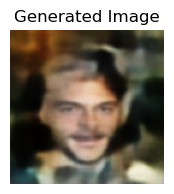

In [30]:
model.eval()

with torch.no_grad():
    random_latent = torch.randn(1, latent_dim).to(device)
    generated_image = model.decode(random_latent)
    generated_image = generated_image.cpu().squeeze(0).detach().numpy()
    generated_image = generated_image.transpose(1, 2, 0)+1
    
plt.figure(figsize=(2, 2))
plt.imshow(generated_image/2)
plt.title("Generated Image")
plt.axis('off')
plt.show()

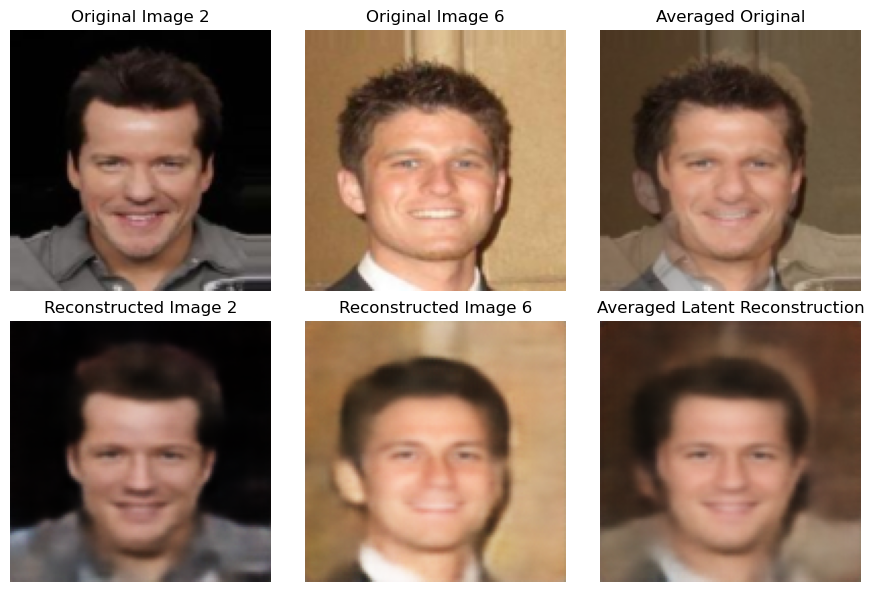

In [35]:
i, j = 2, 6

image_tensor_i = dataset[i]
image_tensor_j = dataset[j]

img_i = image_tensor_i.unsqueeze(0).to(device)
img_j = image_tensor_j.unsqueeze(0).to(device)

with torch.no_grad():
    mu_i, logvar_i = model.encode(img_i)
    mu_j, logvar_j = model.encode(img_j)

    latent_rep_i = model.reparameterize(mu_i, logvar_i)
    latent_rep_j = model.reparameterize(mu_j, logvar_j)

    reconstructed_image_i = model.decode(latent_rep_i).cpu().squeeze(0).detach().numpy()
    reconstructed_image_j = model.decode(latent_rep_j).cpu().squeeze(0).detach().numpy()

    averaged_latent = (latent_rep_i + latent_rep_j) / 2
    reconstructed_image_avg = model.decode(averaged_latent).cpu().squeeze(0).detach().numpy()

    image_i = image_tensor_i.permute(1, 2, 0).cpu().numpy()
    image_j = image_tensor_j.permute(1, 2, 0).cpu().numpy()

    reconstructed_image_i = reconstructed_image_i.transpose(1, 2, 0)
    reconstructed_image_j = reconstructed_image_j.transpose(1, 2, 0)
    reconstructed_image_avg = reconstructed_image_avg.transpose(1, 2, 0)

    image_i = (image_i + 1) / 2
    image_j = (image_j + 1) / 2
    reconstructed_image_i = (reconstructed_image_i + 1) / 2
    reconstructed_image_j = (reconstructed_image_j + 1) / 2
    reconstructed_image_avg = (reconstructed_image_avg + 1) / 2


plt.figure(figsize=(9, 6))

plt.subplot(2, 3, 1)
plt.imshow(image_i)
plt.title(f'Original Image {i}')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_j)
plt.title(f'Original Image {j}')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow((image_i + image_j) / 2)
plt.title(f'Averaged Original')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(reconstructed_image_i)
plt.title(f'Reconstructed Image {i}')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(reconstructed_image_j)
plt.title(f'Reconstructed Image {j}')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(reconstructed_image_avg)
plt.title(f'Averaged Latent Reconstruction')
plt.axis('off')

# Show the plot
plt.tight_layout()
#plt.savefig("vae.png")
plt.show()


In [40]:
model.load_state_dict(torch.load(f'model_weights_{latent_dim}.pth', weights_only=True))

<All keys matched successfully>

In [37]:
output_dir1 = f"reconstructed_images_{latent_dim}dim_celeba_final"
os.makedirs(output_dir1, exist_ok=True)

folder_path = "celebA_class_dataset/Smiling_Male_Young"
#folder_path = "celebA_class_dataset/Smiling_Young_Not_Male"

batch_size=256
dataset = CelebADataset(folder_path=folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=16)

# Set the model to evaluation mode
model.eval()  # Ensure layers like dropout and batch normalization behave correctly during inference

# Transformation to convert tensor to image
to_pil_image = transforms.ToPILImage()

# Iterate over the training set with tqdm for progress bar
with torch.no_grad():  # Disable gradient computation for inference
    for i, images in tqdm(enumerate(dataloader), total=len(dataloader)):
        images = images.to(device)  # Move images to device (GPU/CPU)

        reconstructed_images, _, _ = model(images)

        for j in range(reconstructed_images.size(0)):  # Iterate over batch size
            # Process reconstructed image
            reconstructed_image = (reconstructed_images[j] + 1) / 2  # Normalize the reconstructed image
            reconstructed_image_pil = to_pil_image(reconstructed_image.cpu())  # Convert to PIL image

            # Save reconstructed image
            reconstructed_image_pil.save(f"{output_dir1}/reconstructed_{i * batch_size + j}.jpg", format='JPEG')


100%|██████████| 80/80 [00:31<00:00,  2.55it/s]


In [39]:
import fid_helper
output_dir1 = f"reconstructed_images_{latent_dim}dim_celeba_final"
celeba = "celebA_class_dataset/Smiling_Male_Young"
fid_helper.compute_fid(celeba, output_dir1);

Loading images from celebA_class_dataset/Smiling_Male_Young: 100%|██████████| 20473/20473 [00:25<00:00, 808.40it/s]


20472 Images


Loading images from reconstructed_images_1024dim_celeba_final: 100%|██████████| 20472/20472 [00:15<00:00, 1305.95it/s]


20472 Images


Processing generated images: 100%|██████████| 1280/1280 [00:48<00:00, 26.55it/s]


FID Score: 46.721778869628906


In [73]:
def get_latent_representation(index):
    image_tensor = dataset[index]
    img = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        mu, logvar = model.encode(img)
    return mu, logvar

def decode_latent_representation(mu, logvar):
    with torch.no_grad():
        latent_rep = model.reparameterize(mu, logvar)
        reconstructed_image = model.decode(latent_rep)
    return reconstructed_image

def visualize_images(original_image_tensor, reconstructed_image_tensor):

    # Process the reconstructed image
    reconstructed_image = reconstructed_image_tensor.cpu().squeeze(0).detach().numpy()
    reconstructed_image = reconstructed_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    reconstructed_image = (reconstructed_image + 1) / 2  # Rescale to [0, 1]

    # Process the original image
    image = original_image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
    image = (image + 1) / 2  # Rescale to [0, 1]

    # Plot the original and reconstructed images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()


In [79]:
negative_infinity = torch.full((1, latent_dim), float('-inf')).to(device)

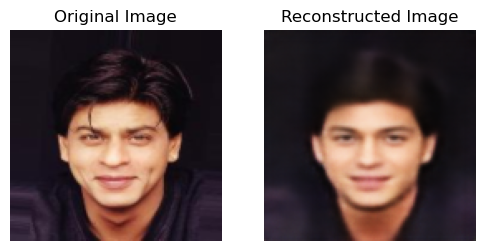

In [183]:
i = 9
visualize_images(dataset[i], decode_latent_representation(get_latent_representation(i)[0], negative_infinity))

#### Negative Infinity to simulate sampling from only mean (to get deterministic result) ####

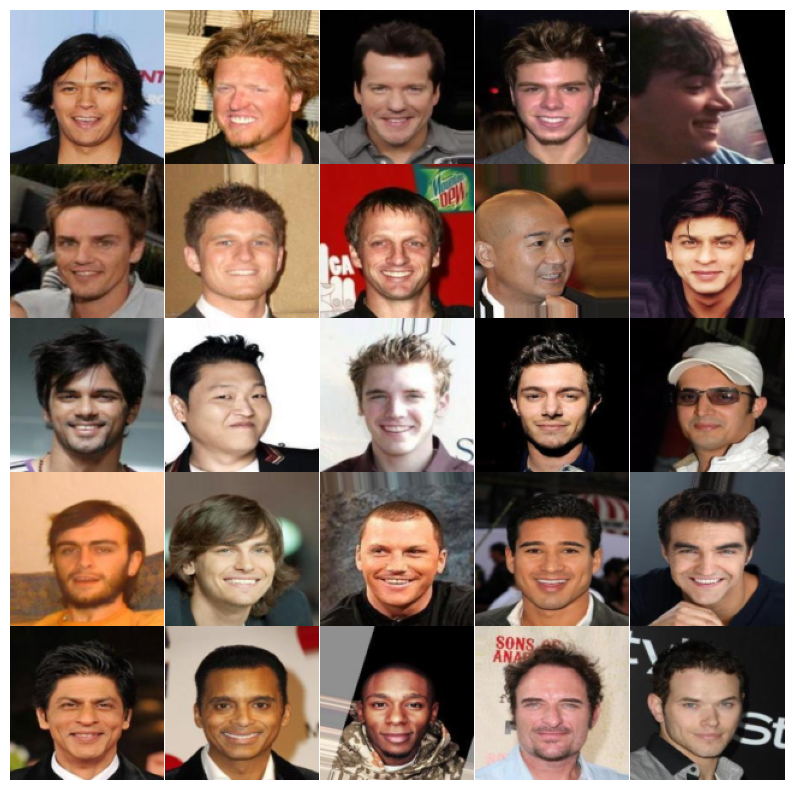

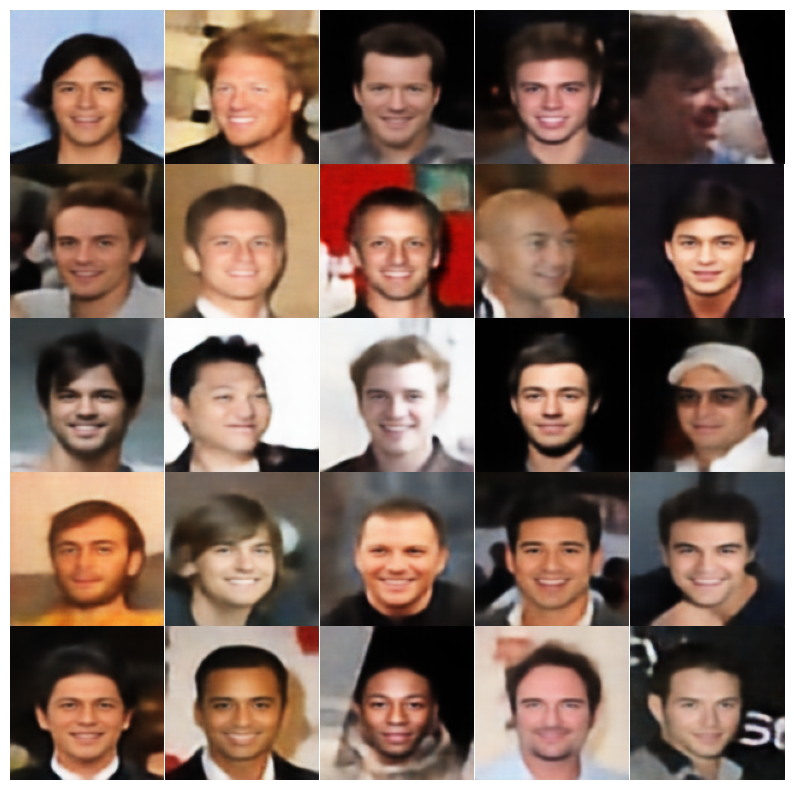

In [96]:
import matplotlib.pyplot as plt

k = 5 
fig1, axes1 = plt.subplots(k, k, figsize=(10, 10))

fig2, axes2 = plt.subplots(k, k, figsize=(10, 10))

for i in range(k):
    for j in range(k):
        index = i * k + j  # Calculate the index for accessing the dataset

        # Get the original image
        imageij = dataset[index]
        
        # Get the reconstructed image
        reconsij = decode_latent_representation(get_latent_representation(index)[0], negative_infinity)
        
        # Process the original image
        image = imageij.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
        image = (image + 1) / 2  # Rescale to [0, 1]

        # Process the reconstructed image
        reconstructed_image = reconsij.cpu().squeeze(0).detach().numpy()
        reconstructed_image = reconstructed_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        reconstructed_image = (reconstructed_image + 1) / 2  # Rescale to [0, 1]

        # Plot the original (real) image in the first figure
        axes1[i, j].imshow(image)
        axes1[i, j].axis('off')  # Hide axes and values

        # Plot the reconstructed (generated) image in the second figure
        axes2[i, j].imshow(reconstructed_image)
        axes2[i, j].axis('off')  # Hide axes and values

# Adjust layout for both figures to reduce white space
fig1.subplots_adjust(wspace=0, hspace=0)  # Set horizontal and vertical spacing to 0 for the first plot
fig2.subplots_adjust(wspace=0, hspace=0)  # Set horizontal and vertical spacing to 0 for the second plot

# Show both plots
plt.show()


In [181]:
def visualize_images_r(reconstructed_image_tensor):

    reconstructed_image = reconstructed_image_tensor.cpu().squeeze(0).detach().numpy()
    reconstructed_image = reconstructed_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    reconstructed_image = (reconstructed_image + 1) / 2  # Rescale to [0, 1]

    # Plot the original and reconstructed images
    plt.figure(figsize=(2, 2))
    plt.imshow(reconstructed_image)
    plt.axis('off')
    plt.show()

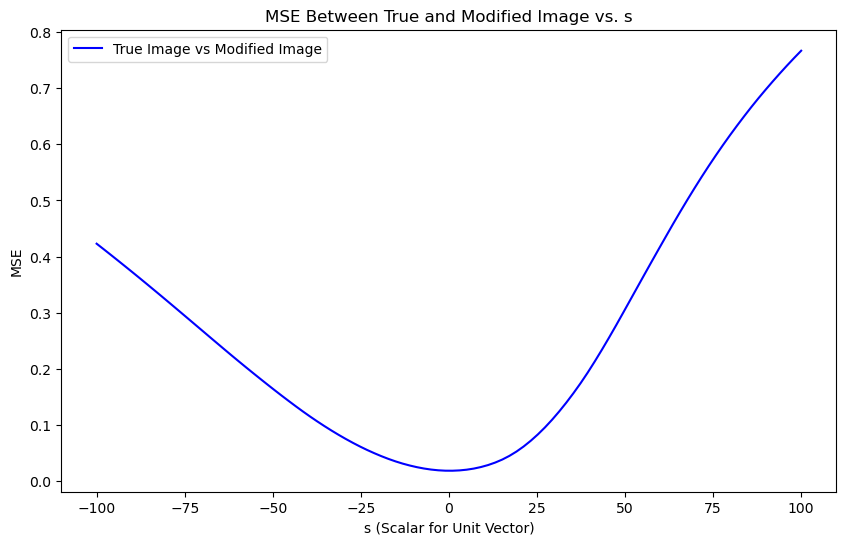

In [195]:
random_vector = torch.randn(1, 1024)

unit_vector = random_vector / random_vector.norm(p=2, dim=1, keepdim=True)

# Ensure it's of the same type (float32) and on the same device as the original vector
unit_vector = unit_vector.to(dtype=torch.float32).to(device)

# Define MSE calculation function
def mse_loss(image1, image2):
    return torch.mean((image1 - image2) ** 2)

# Initialize a list to store MSE values
s_values = np.linspace(-100, 100, 100)  # adjust the range and number of points
mse_true_vs_modified = []

# Index of the image
i = 7

# Get the true image, move to GPU
true_image = dataset[i].to(device)
# Loop over the s values and compute MSE for each s
for s in s_values:
    modified_latent = get_latent_representation(i)[0] + s * unit_vector
    recons_image_modified = decode_latent_representation(modified_latent, negative_infinity)

    # Compute MSE between true_image and modified_image
    mse_true = mse_loss(true_image, recons_image_modified)
    mse_true_vs_modified.append(mse_true.item())  # Append the MSE value

plt.figure(figsize=(10, 6))
plt.plot(s_values, mse_true_vs_modified, label="True Image vs Modified Image", color='blue')
plt.xlabel('s (Scalar for Unit Vector)')
plt.ylabel('MSE')
plt.title('MSE Between True and Modified Image vs. s')
plt.legend()
plt.savefig('MSE.png')
plt.show()

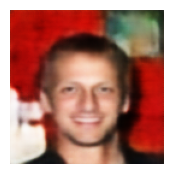

In [196]:
visualize_images_r(decode_latent_representation(get_latent_representation(i)[0] + 10*unit_vector,negative_infinity))